On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model
of shoe. We want to do some analysis of the average order value (AOV). When we look at
orders data​ over a 30 day window, we naively calculate an AOV of $3145.13. Given that we
know these shops are selling sneakers, a relatively affordable item, something seems wrong
with our analysis. Think about what could be going wrong with our calculation. Think about a
better way to evaluate this data.

***What to submit:*** Which metric you would report for this dataset, and its value in dollars?

-------------------------------------------------------------------
***Short Answer:*** To mitigate the influence of records which are likely erronous and skewing the AOV, using the ***median*** as a metric would be advisable. (\$284)

***Long Answer:*** Trying to define something as an "outlier" in this data set is somewhat precarious as "relatively affordable" is a relative measure. However, in the rest of the notebook I will try and remove the (potentially) erroneous records and compare a new AOV from the cleansed data to asses the validity of using the median on the original data as an alternative to the AOV metric.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv")

print("Median of Data: ",df.order_amount.median())

Median of Data:  284.0


In [2]:
# Exclude metrics on id fields as they are irrelevant 
df.describe()[['order_amount', 'total_items']]

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


Examaning the data we can see that the percentile ranges look a bit odd in comparison to the max and min values. 75% of all orders are less than \$390 in value, but the max order val is $704000. Similarly in the total items it seems unlikely that a customer ordering "reasonably affordable" shoes from a presumably consumer oriented web store would be ordering 2000 items. 

These values are likely skewing the data and may be worth dropping. First lets take a closer look at some of the data.

In [3]:
# How many unique item counts are there over all the orders?
print(df.total_items.unique())
print(df.total_items.quantile([.80, .90, .95, .97, .98, .985, .99]))

[   2    1    3 2000    4    5    6    8]
0.800    3.0
0.900    3.0
0.950    4.0
0.970    4.0
0.980    5.0
0.985    5.0
0.990    5.0
Name: total_items, dtype: float64


Again the orders with 2000 items seem suspect as of the 8 classes of order volume, 7 of them are less than 9 in volume. Also 99% of the orders are for 5 items or less. Perhaps 6 and 8 are also "outliers"?

In [4]:
for index, row in df.iterrows():
    if(row['total_items'] == 8):
        print(row)
        print("Shoe Price: ", (row["order_amount"]/row["total_items"]))
        

order_id                         4142
shop_id                            54
user_id                           733
order_amount                     1064
total_items                         8
payment_method                  debit
created_at        2017-03-07 17:05:18
Name: 4141, dtype: object
Shoe Price:  133.0


Although an order for 8 shoes seems like alot, the shoes were a "reasonable price" and it is possible that this order was valid.

In [5]:
# Lets check the percentiles for the order dollar values
df.order_amount.quantile([.85, .90, .95, .97, .98, .985, .9867, .99])

0.8500      483.0000
0.9000      531.0000
0.9500      640.0000
0.9700      712.0000
0.9800      800.0800
0.9850      948.1800
0.9867     1075.2926
0.9900    25725.0000
Name: order_amount, dtype: float64

Examining the percentiles for order values we can see 98.5% of all orders are less than \$950. It also apears odd that in the top 1 percent of orders, there exist orders for more than \$25000 from a consumer facing store. These may be eroneous and worth excluding / cleansing from the data set.

In [6]:
# Lets take a subsection of the suspicious high cost orders
wf = df.copy()
# To avoid throwing out any orders accidentially, set the cuttoff
# Point to 2000, ~2x the order value @ the 98.67th quantile
for index, row in wf.iterrows():
    if(row["order_amount"] < 2000):
        wf.drop(index, inplace=True)

# Create new field to check shoe price on order
shoe_val = []

for index, row in wf.iterrows():
    this_shoe = row["order_amount"]/row["total_items"]
    shoe_val.append(this_shoe)
    
shoe_series = pd.Series(shoe_val)
wf['price_per_shoe'] = shoe_series.values

# Display suspicious orders desceding
wf.sort_values("order_amount", ascending=False)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price_per_shoe
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
2835,2836,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0
2969,2970,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,352.0
4056,4057,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,352.0


In reviewing the above data, we can see that orders for merchandise totalling over \$2000 are either...
    - Appropriately priced per shoe but unresonable volume
    - Reasonable item volume but unreasonable shoe value
    
We are likely safe to assume that these are erroneous records. Lets drop them from the data and see how it effects the average.

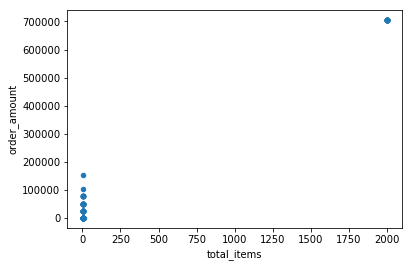

In [7]:
# Here we can visually see outliers
df.plot.scatter(x='total_items', y='order_amount')
plt.show()

In [8]:
#Drop orders above 2000
for index, row in df.iterrows():
    if(row["order_amount"] > 2000):
        df.drop(index, inplace=True)
        
df.order_amount.mean()

302.58051448247926

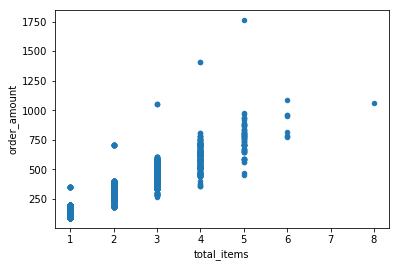

In [9]:
# And the same graph after dropping
df.plot.scatter(x='total_items', y='order_amount')
plt.show()

Seems like there are still some possible outliers. Lets check them out as well.

In [21]:
# Max order amount per order size
mx_vals = df.groupby(['total_items'])['order_amount'].max()
mx_vals

total_items
1     352
2     704
3    1056
4    1408
5    1760
6    1086
8    1064
Name: order_amount, dtype: int64

The above all seem reasonable with a shoe price of \$352 or less each so they can stay. Now lets compare the median as a metric to the AOV of the cleansed data. 

In [56]:
df.order_amount.mean()

302.58051448247926

This value is closer to what the actual mean should be. The original median value of 284 is relatively close to this mean and certainly much closer than the initial AOV value of 3000+

In [69]:
init_error = (3145.13 - df.order_amount.mean())/df.order_amount.mean()
print("Initial AOV Error: {} %".format(init_error*100))

median_metric = (df.order_amount.mean() - 284)/df.order_amount.mean()
print("Median Metric Vs. True Mean, Error: {} %".format(median_metric*100))

Initial AOV Error: 939.4357367589568 %
Median Metric Vs. True Mean, Error: 6.1406844106463945 %
